# Controllers and Tasks

This notebook will demonstrate the basic workflow for controllers and tasks.

## Set-Up

First we will import AutoMPC and generate our system identification dataset as before.

In [10]:
import autompc as ampc
import numpy as np
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark()

system = benchmark.system
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

Next, we will create a System ID model to be used by the controller.  Here, we will use the SINDy model.

In [11]:
from autompc.sysid import SINDy

model = SINDy(system, method="lstsq", trig_basis=True, trig_interaction=True)
model.train(trajs)

## Task

Although the benchmark provides a task, we will define a new task here for demonstration.  First, we need to define an objective function to associate with the task.  Here we use a quadratic cost

In [12]:
from autompc.costs import QuadCost

Q = np.diag([30.0, 3.0, 0.005, 0.1])
R = np.diag([0.02])
F = np.diag([2.0, 3000, 0.15, 0.3])
cost = QuadCost(system, Q, R, F, goal=np.zeros(4))

Now, we initialize the Task and set the cost.  We can also use the task to set bounds on the controls, here we bound the `"u"` control between -20 and +20.

In [13]:
from autompc.tasks import Task

task = Task(system)
task.set_cost(cost)
task.set_ctrl_bound("u", -20.0, 20.0)

## Controller

Now, we can create our controller.  As with System ID models, there are two ways to create a controller: instantiating the controller directly, or using a controller factory.  Here we use the former approach, but for more information on controller factories, see [4. Factories and Pipelines](https://github.com/williamedwards/autompc/tree/main/examples).

Here we demonstrate an iLQR controller with optimization horizon 10. To see all available controllers, see [here](https://autompc.readthedocs.io/en/latest/source/control.html#supported-controllers).

It's also necessary to pass the system, the task, and the system ID model to the controller.

In [15]:
from autompc.control import IterativeLQR

controller = IterativeLQR(system, task, model, horizon=10)

To run the controller, we need to initialize the controller state.  We can do this using the `traj_to_state` method.

The controller state includes the necesary information about the history of the trajectory to run the control optimization.  For example, if the controller is using an ARX system ID model, than the controller state will include a history of the last several observations and controls, since the ARX model needs this information to make predictions.

In [6]:
# Create stub trajectory
traj = ampc.zeros(system, 1)
traj[0].obs[:] = np.array([3.14, 0.0, 0.0, 0.0])

# Initialize controller state
controller_state = controller.traj_to_state(traj)

We then run the controller by passing the state and the most recent observation. This gives us the control for the current time step, and the new control state.

In [16]:
u, newstate = controller.run(controller_state, np.array([3.14, 0.0, 0.0, 0.0]))
u

array([20.])

Note that controllers may have some state information not contained in controller_state.  This is typically a control guess for warm-starting optimization.  To clear this state, call `controller.reset()`

By repeatedly calling run, we can simulate the behavior of the controller. To make this easier, we provide the simulate function.

In [17]:
traj = ampc.simulate(controller, init_obs=np.array([3.14, 0.0, 0.0, 0.0]), max_steps=200, dynamics=benchmark.dynamics)

100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


We can the visualize the resulting trajectory

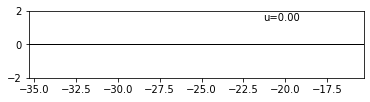

In [18]:
import matplotlib.pyplot as plt
from IPython.display import HTML

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj)
HTML(anim.to_html5_video())